# Model 3

## Matrix Factorisation

This is a classical collaborative filtering Model

In [1]:
import sys
sys.path.append("../")

import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
from IPython.display import SVG, display
import matplotlib.pyplot as plt
import seaborn as sns
from reco.preprocess import encode_user_item, random_split, user_split

In [3]:
%matplotlib inline

## Prepare The data

In [4]:
df_ratings = pd.read_csv("data/ratings.csv")
df_items = pd.read_csv("data/items.csv")

In [5]:
# Data Encoding
DATA, user_encoder, item_encoder = encode_user_item(df_ratings, "user_id", "movie_id", "rating", "unix_timestamp")

Number of users:  943
Number of items:  1682


In [6]:
DATA.head()

,user_id,movie_id,RATING,TIMESTAMP,USER,ITEM
0,196,242,3,881250949,195,241
1,186,302,3,891717742,185,301
2,22,377,1,878887116,21,376
3,244,51,2,880606923,243,50
4,166,346,1,886397596,165,345


In [7]:
n_users = DATA.USER.nunique()
n_items = DATA.ITEM.nunique()
n_users, n_items

(943, 1682)

In [8]:
max_rating = DATA.RATING.max()
min_rating = DATA.RATING.min()
min_rating, max_rating

(1, 5)

In [9]:
# Data Splitting
train, val, test = user_split(DATA, [0.6, 0.2, 0.2])
#train, test = random_split(DATA, [0.8, 0.2])

In [10]:
train.shape,test.shape

((60014, 7), (20000, 7))

## Explicit Model Factorisation

This is a model with User And Item Embedding Dot Product

In [11]:
from keras.models import Model
from keras.layers import Input, Embedding, Flatten, Dot, Add, Lambda, Activation, Reshape
from keras.regularizers import l2
from keras.constraints import non_neg
#from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot
from reco import vis

In [12]:
def ExplicitMF (n_users, n_items, n_factors):
    
    # Item Layer
    item_input = Input(shape=[1], name='Item')
    item_embedding = Embedding(n_items, n_factors, 
                               embeddings_regularizer=l2(1e-6), 
                               name='ItemEmbedding')(item_input)
    item_vec = Flatten(name='FlattenItemsE')(item_embedding)

    # User Layer
    user_input = Input(shape=[1], name='User')
    user_embedding = Embedding(n_users, n_factors, 
                               embeddings_regularizer=l2(1e-6), 
                               name='UserEmbedding')(user_input)
    user_vec = Flatten(name='FlattenUsersE')(user_embedding)

    # Dot Product of Item and User
    rating = Dot(axes=1, name='DotProduct')([item_vec, user_vec])
    
    # Model Creation
    model = Model([user_input, item_input], rating)
    
    # Compile Model
    model.compile(loss='mean_squared_error', optimizer="adam")
    
    return model

In [13]:
n_factors = 40
model = ExplicitMF(n_users, n_items, n_factors)

In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
User (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
ItemEmbedding (Embedding)       (None, 1, 40)        67280       Item[0][0]                       
__________________________________________________________________________________________________
UserEmbedding (Embedding)       (None, 1, 40)        37720       User[0][0]                       
______________________________________________________________________________________________

In [19]:
%%time
output = model.fit([train.USER, train.ITEM], train.RATING, 
                                  batch_size=128, epochs=100, verbose=1, validation_split=0.2)

Epoch 1/100
376/376 [==============================] - 0s 1ms/step - loss: 0.6472 - val_loss: 13.7984
Epoch 2/100
376/376 [==============================] - 0s 969us/step - loss: 0.6231 - val_loss: 13.7985
Epoch 3/100
376/376 [==============================] - 0s 964us/step - loss: 0.5985 - val_loss: 13.7987
Epoch 4/100
376/376 [==============================] - 0s 960us/step - loss: 0.5733 - val_loss: 13.7989
Epoch 5/100
376/376 [==============================] - 0s 948us/step - loss: 0.5475 - val_loss: 13.7991
Epoch 6/100
376/376 [==============================] - 0s 962us/step - loss: 0.5218 - val_loss: 13.7992
Epoch 7/100
376/376 [==============================] - 0s 913us/step - loss: 0.4955 - val_loss: 13.7994
Epoch 8/100
376/376 [==============================] - 0s 976us/step - loss: 0.4694 - val_loss: 13.7996
Epoch 9/100
376/376 [==============================] - 0s 936us/step - loss: 0.4434 - val_loss: 13.7998
Epoch 10/100
376/376 [==============================] - 0s 951us/s

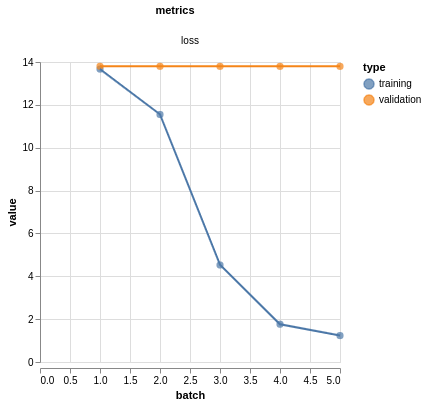

In [16]:
vis.metrics(output.history)

In [20]:
score = model.evaluate([test.USER, test.ITEM], test.RATING, verbose=1)
score

625/625 [==============================] - 0s 603us/step - loss: 4.1614


4.161369323730469

In [21]:
from reco.evaluate import get_embedding, get_predictions, recommend_topk
from reco.evaluate import precision_at_k, recall_at_k, ndcg_at_k

In [22]:
item_embedding = get_embedding(model, "ItemEmbedding")
user_embedding = get_embedding(model, "UserEmbedding")

In [23]:
%%time
predictions = get_predictions(model, DATA)

CPU times: user 19.5 s, sys: 1.35 s, total: 20.8 s
Wall time: 14 s


In [24]:
predictions.head()

,USER,ITEM,RATING_PRED
0,195,241,3.058987
1,195,301,4.698982
2,195,376,1.955924
3,195,50,3.761109
4,195,345,1.952229


In [25]:
%%time
# Recommendation for Top10K
ranking_topk = recommend_topk(model, DATA, train, k=5)

CPU times: user 20.8 s, sys: 1.55 s, total: 22.4 s
Wall time: 15.9 s


In [26]:
eval_precision = precision_at_k(test, ranking_topk, k=10)
eval_recall = recall_at_k(test, ranking_topk, k=10)
eval_ndcg = ndcg_at_k(test, ranking_topk, k=10)

print("NDCG@K:\t%f" % eval_ndcg,
      "Precision@K:\t%f" % eval_precision,
      "Recall@K:\t%f" % eval_recall, sep='\n')

NDCG@K:	0.036639
Precision@K:	0.026193
Recall@K:	0.013252


In [35]:
from reco.recommend import get_similar, show_similar

In [37]:
%%time
item_distances, item_similar_indices = get_similar(item_embedding, 5)

CPU times: user 94.4 ms, sys: 0 ns, total: 94.4 ms
Wall time: 94.4 ms


In [38]:
item_similar_indices

array([[   0, 1048,  198, 1532, 1606],
       [   1,  965, 1317,  903,  267],
       [   2, 1048, 1299,  181, 1208],
       ...,
       [1679, 1257,  939,  735,  987],
       [1680, 1660, 1507,  335,  804],
       [1681,  157, 1625,  823, 1217]])

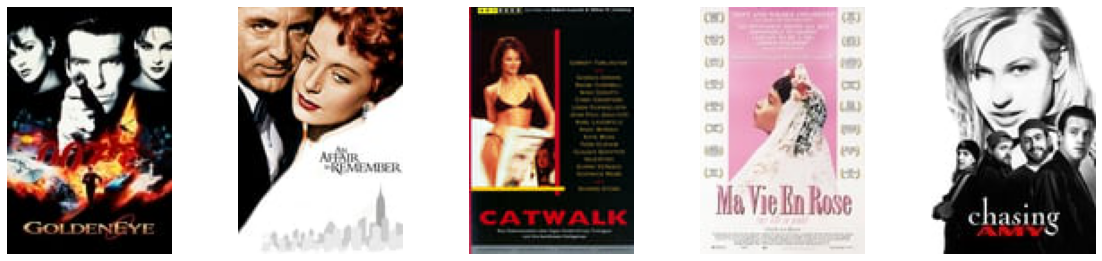

In [40]:
show_similar(1, item_similar_indices, item_encoder)